In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt
from lib.gen_utils import *

In [11]:
def show_image(images, titles=None):
    # show image horizontally
    fig, ax = plt.subplots(1, len(images), figsize=(5 * len(images), 5))

    for i, image in enumerate(images):
        if len(image.shape) == 3:
            fig.axes[i].imshow(image)
        else:
            fig.axes[i].imshow(image, cmap="gray")
        if titles:
            fig.axes[i].set_title(titles[i])
    plt.show()

In [12]:
from Rain_Effect_Generator import RainEffectGenerator

In [13]:
HEIGHT = 255
WIDTH = 255

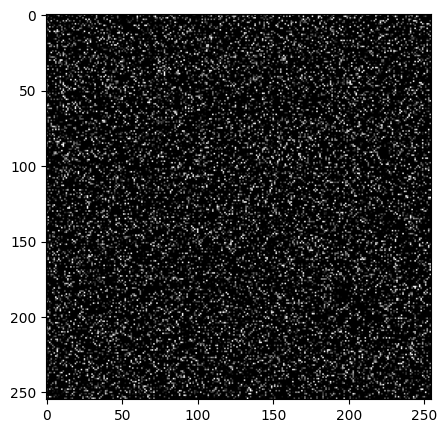

In [14]:
noise = generate_noisy_image(HEIGHT, WIDTH)
show_image([noise])

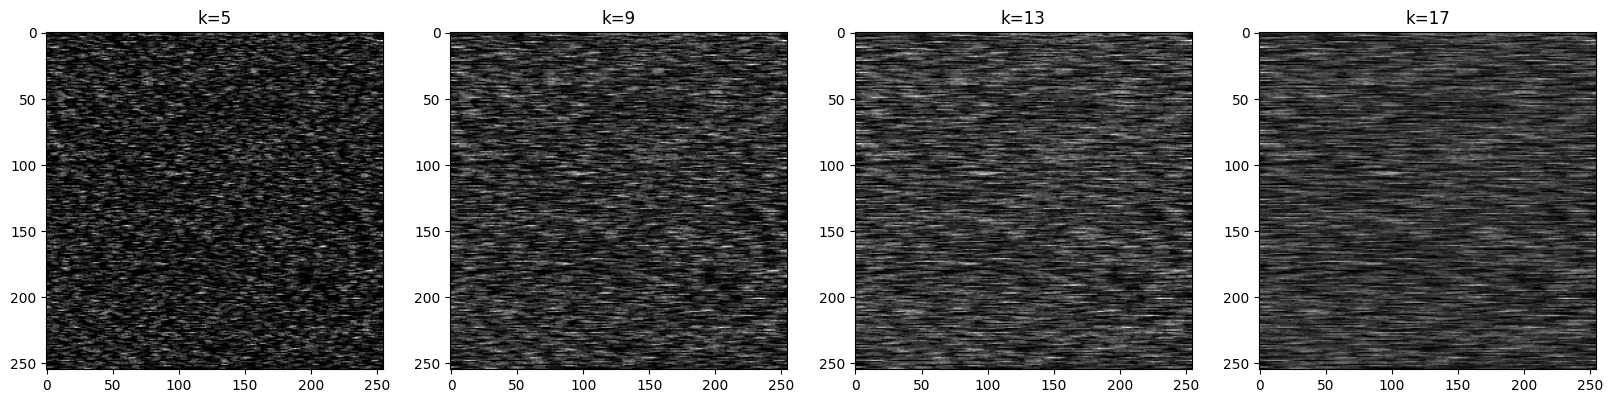

In [15]:
blur_kernels = [5, 9, 13, 17]

blur_noise = [apply_motion_blur_(noise, k) for k in blur_kernels]

show_image(blur_noise, titles=[f"k={k}" for k in blur_kernels])

In [ ]:
angples = [30, 45, 60, 90]

rotate_noise = [apply_motion_blur_(noise, 9, angle=angle) for angle in angples]

show_image(rotate_noise, titles=[f"angle={angle}" for angle in angples])

In [16]:
rain_generator = RainEffectGenerator()

In [17]:
rain_angle = 60

## Generate rain layer by combining multiple layers

Let $L_1, L_2, \ldots, L_n$ be $n$ layers of rain.

$$
x


$$


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

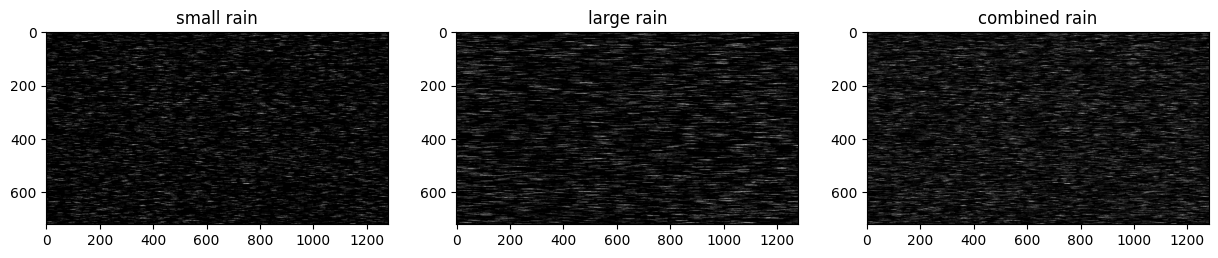

In [18]:
large_rain_layer = rain_generator._rain_layer_gen.genRainLayer(
    h=720,
    w=1280,
    blur_kernel_size=23,
    blur_angle=rain_angle,
)  # large

small_rain_layer = rain_generator._rain_layer_gen.genRainLayer(
    h=720,
    w=1280,
    blur_kernel_size=11,
    blur_angle=rain_angle,
)  # small

rain_layer = layer_blend(small_rain_layer, large_rain_layer)

show_image(
    [small_rain_layer, large_rain_layer, rain_layer],
    ["small rain", "large rain", "combined rain"],
)